# Layered Embeddings

## Initialise

In [1]:
!pip install graphdatascience python-dotenv umap-learn scikit-learn==1.4.2 matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience, Graph

def drop_graph_if_exists(gds: GraphDataScience,
                         projections: list):
  """Drop named GDS projections in list.

  Args:
    gds : GraphDataScience
      Neo4j GDS session object
    projections: list
      List of projection names
  """
  # Check for existence of each named projection
  filtered_projections = list(filter(lambda x: x in projections, gds.graph.list()['graphName']))
  # Drop projections
  _ = list(map(lambda x: gds.graph.drop(gds.graph.get(x)), filtered_projections))


def reduce_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', reduce_column='reduced'):
  # Apply dimensionality reduction algorithm to embedding
  transformed = algorithm.fit_transform(np.array(list(df[property_column])))

  # Concatenate reduced transformation into Dataframe
  dfX = pd.concat([df, pd.Series(list(transformed))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [reduce_column], axis=1)
  return dfX


def cluster_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', cluster_column='cluster'):
  # Apply clustering algorithm to embedding
  algorithm.fit(np.array(list(df[property_column])))

  # Concatenate cluster labels into Dataframe
  dfX = pd.concat([df, pd.DataFrame(list(algorithm.labels_))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [cluster_column], axis=1)
  return dfX


def node_property_project(gds: GraphDataScience, projection_name: str, df: pd.DataFrame, nodeId_column: str, property_columns: list, labels: list):
  # Create empty DataFrame for nodes
  nodes = pd.DataFrame()

  # Set nodeId column
  nodes['nodeId'] = df[nodeId_column]

  # Add property columns to nodes dataframe
  for v in property_columns:
    nodes[v] = df[v]

  # Add a column for node labels
  nodes['labels'] = nodes.apply(lambda x: labels, axis='columns')

  # Empty dataframe - we don't need any relationships
  relationships = pd.DataFrame()

  # Create graph projection of nodes & properties from dataframe
  return gds.graph.construct(projection_name, nodes, relationships)


In [3]:
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap
import time

from dotenv import load_dotenv
import os
import random
import pandas as pd
pd.set_option('display.max_rows', 100)
load_dotenv()

NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )

from neo4j import GraphDatabase
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)
n4j = driver.session(database=NEO4J_DB)


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

## Create Graph

In [4]:
nA = 2000
nB = 2000
nZ = 10
connections = 2

#nA = 2000
#nB = 2000
#nZ = 5
#connections = 3

nA = 10000
nB = 10000
nZ = 7
connections = 4

n4j.run('MATCH (n) DETACH DELETE n')

n4j.run("CREATE CONSTRAINT a_name IF NOT EXISTS FOR (n:A) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT b_name IF NOT EXISTS FOR (n:B) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT z_name IF NOT EXISTS FOR (n:Z) REQUIRE (n.name) IS UNIQUE")

n4j.run("UNWIND $records AS row MERGE (:A {name: row})", records=list(range(nA)))
n4j.run("UNWIND $records AS row MERGE (:B {name: row})", records=list(range(nB)))
n4j.run("UNWIND $records AS row MERGE (:Z {name: row})", records=list(range(nZ)))

n4j.run("UNWIND $records AS row MATCH (a:A {name: row}) MATCH (b:B {name: row}) MERGE (a)-[:FOLLOW]->(b)", records=list(range(nA)))

# Generate random traits
traits = list(map(lambda x: [x, random.sample(range(nZ), connections)], range(nA)))

n4j.run("UNWIND $records AS row MATCH (b:B {name: row[0]}) UNWIND row[1] AS x MATCH (z:Z {name: x}) MERGE (b)-[:TRAIT]->(z)", records=traits)
time.sleep(3)

## Approach A - Direct

### Project

In [5]:
PROJECTION1 = 'ABZ'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION1], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    //MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

G, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION1)
result
gds.graph.list()
import time
time.sleep(5)

### Embed

In [6]:
EMBEDDING1 = 'fastRP1'
EMBEDDING_DIMENSION = 128
RANDOM_SEED = 42
GA = gds.graph.get(PROJECTION1)
gds.fastRP.mutate(GA, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING1, randomSeed=RANDOM_SEED, nodeLabels=['B', 'Z'])

nodePropertiesWritten                                                10007
mutateMillis                                                             0
nodeCount                                                            10007
preProcessingMillis                                                      0
computeMillis                                                           45
configuration            {'randomSeed': 42, 'mutateProperty': 'fastRP1'...
Name: 0, dtype: object

### Stream B embeddings

In [7]:
dfBe = gds.graph.nodeProperty.stream(GA, EMBEDDING1, 'B')

### Cluster, reduce, cluster

In [8]:
%%time
dfBc = cluster_embedding(dfBe, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
dfBc = reduce_embedding(dfBc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
dfBc = cluster_embedding(dfBc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')

CPU times: user 1min 26s, sys: 774 ms, total: 1min 27s
Wall time: 24.1 s


### Raw Clusters

In [9]:
dfBc['raw'].value_counts()

raw
31    319
17    316
11    313
18    312
23    309
8     309
2     302
21    298
14    297
26    294
29    293
34    293
6     292
24    291
3     289
27    284
7     284
19    282
33    281
22    279
25    279
1     277
5     277
4     277
9     277
32    276
16    276
15    274
0     273
30    267
28    267
20    265
12    261
13    260
10    257
Name: count, dtype: int64

### UMAP Clusters

In [10]:
dfBc['umap'].value_counts()

umap
3     319
5     316
7     313
21    312
17    309
14    309
18    302
8     298
11    297
15    294
9     293
16    293
28    292
24    291
20    289
30    284
29    284
13    282
10    281
12    279
1     279
27    277
4     277
31    277
32    277
19    276
25    276
33    274
34    273
0     267
2     267
26    265
35    260
6     257
23    231
22     30
Name: count, dtype: int64

### UMAP Cluster Plot

<Axes: xlabel='x', ylabel='y'>

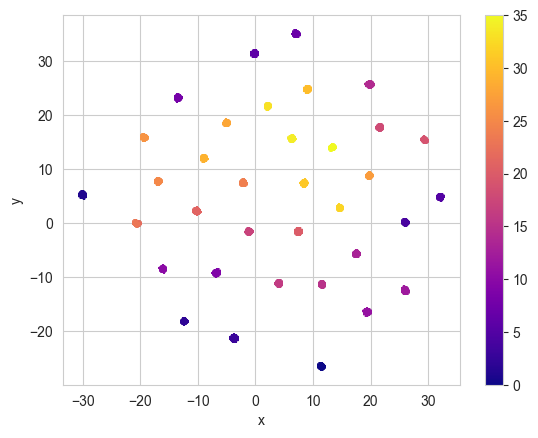

In [11]:
dfBc['x'] = dfBc['reduced'].apply(lambda x: x[0])
dfBc['y'] = dfBc['reduced'].apply(lambda x: x[1])
dfBc.plot.scatter(x='x', y='y', c=dfBc['umap'], cmap="plasma", marker='+')

## Approach B - Layered

### Project

In [12]:
PROJECTION2 = 'ABZ2'
PROJECTION3 = 'ABZ3'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION2, PROJECTION3], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    //MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

GB, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION2)
result

relationshipCount                                               100000
graphName                                                         ABZ2
query                \nCALL {\n    MATCH (a:A)-[r1:FOLLOW]->(b:B)\n...
projectMillis                                                       37
configuration        {'readConcurrency': 4, 'undirectedRelationship...
nodeCount                                                        20007
dtype: object

### Embed B to Z

In [13]:
EMBEDDING2 = 'fastRP2'
GB = gds.graph.get(PROJECTION2)
gds.fastRP.mutate(GB, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING2, nodeLabels=['B', 'Z'], randomSeed=RANDOM_SEED)

nodePropertiesWritten                                                10007
mutateMillis                                                             0
nodeCount                                                            10007
preProcessingMillis                                                      0
computeMillis                                                           29
configuration            {'randomSeed': 42, 'mutateProperty': 'fastRP2'...
Name: 0, dtype: object

### WCC for node property

In order to stream nodeIds a node must have a property - fix to add a property for A nodes.

In [14]:
gds.wcc.mutate(GB, mutateProperty='wcc')

mutateMillis                                                             0
nodePropertiesWritten                                                20007
componentCount                                                           1
componentDistribution    {'min': 20007, 'p5': 20007, 'max': 20007, 'p99...
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                            1
configuration            {'mutateProperty': 'wcc', 'jobId': '25f3c2f1-7...
Name: 0, dtype: object

### Stream B embeddings

In [15]:
dfB2 = gds.graph.nodeProperty.stream(GB, EMBEDDING2, 'B')
dfB2['labels'] = dfB2.apply(lambda x: ['B'], axis='columns')
dfB2.head()

,nodeId,propertyValue,labels
0,10000,"[0.07881104, 0.07881104, 0.0, 0.0, -0.15762208...",[B]
1,10001,"[0.0, 0.0, 0.0, -0.07124705, -0.07124705, 0.0,...",[B]
2,10002,"[0.14106913, -0.14106913, 0.0, -0.14106913, -0...",[B]
3,10003,"[0.07955573, 0.07955573, 0.0, 0.07955573, -0.0...",[B]
4,10004,"[0.07881104, 0.07881104, 0.0, 0.0, -0.15762208...",[B]


### Stream A nodes

Add zero vectors

In [16]:
dfA1 = gds.graph.nodeProperty.stream(GB, 'wcc', 'A')
dfA1['propertyValue'] = dfA1.apply(lambda x: list(map(lambda x: 0.0, range(EMBEDDING_DIMENSION))), axis='columns')
dfA1['labels'] = dfA1.apply(lambda x: ['A'], axis='columns')
dfA1.head()

,nodeId,propertyValue,labels
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]


### Stream FOLLOW relationships

In [17]:
relationships = gds.graph.relationships.stream(GB, ['FOLLOW'])
relationships.head()

,sourceNodeId,targetNodeId,relationshipType
0,0,10000,FOLLOW
1,10000,0,FOLLOW
2,1,10001,FOLLOW
3,10001,1,FOLLOW
4,2,10002,FOLLOW


### Construct Graph

In [18]:
PROPERTY_RATIO = 0.5
NODE_SELF_INFLUENCE = 0.0

list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION3], gds.graph.list()['graphName']))))
GC = gds.graph.construct(PROJECTION3, pd.concat([dfB2, dfA1]), relationships)

Uploading Nodes:   0%|          | 0/20000 [00:00<?, ?Records/s]

Uploading Relationships:   0%|          | 0/20000 [00:00<?, ?Records/s]

/Users/olgarazvenskaia/.env/fastrp-repr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'TopologyDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'TopologyDataFrame.transpose' instead.
  return bound(*args, **kwds)


### Embed combining graph & previously calculated embeddings

In [34]:
EMBEDDING3 = 'fastRP3'
gds.graph.nodeProperties.drop(GC, EMBEDDING3)
gds.fastRP.mutate(GC, embeddingDimension=EMBEDDING_DIMENSION,
                  iterationWeights=[1.0], nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO, featureProperties=['propertyValue'], mutateProperty=EMBEDDING3)
dfA2 = gds.graph.nodeProperty.stream(GC, EMBEDDING3, 'A')
dfA2.describe()

,nodeId
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


### Stream A Embedding

In [35]:
dfA2 = gds.graph.nodeProperty.stream(GC, EMBEDDING3, 'A')
dfA2.describe()

,nodeId
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


### Cluster, reduce, cluster

In [36]:
%%time
dfAc = cluster_embedding(dfA2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
dfAc = reduce_embedding(dfAc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
dfAc = cluster_embedding(dfAc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')

CPU times: user 38.6 s, sys: 357 ms, total: 39 s
Wall time: 10 s


### Raw Clusters

In [37]:
dfAc['raw'].value_counts()

raw
-1    8702
 0    1276
 1      22
Name: count, dtype: int64

### UMAP Clusters

In [38]:
dfAc['umap'].value_counts()

umap
 7     319
 30    315
 9     313
 22    309
 11    309
 32    308
 10    302
 8     297
 19    296
 24    294
 26    294
 31    293
 17    292
 25    290
 1     289
 28    284
 13    284
 3     282
 29    279
 14    279
 4     277
 27    277
 0     277
 2     277
 16    276
 34    275
 15    274
 12    273
 33    272
 6     267
 5     267
 20    266
 21    261
 23    260
 18    257
-1      16
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

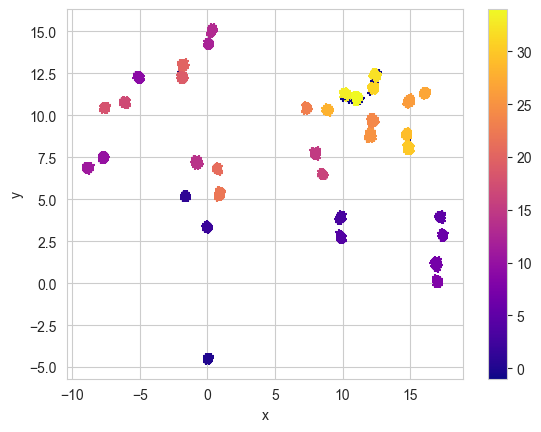

In [39]:
dfAc['x'] = dfAc['reduced'].apply(lambda x: x[0])
dfAc['y'] = dfAc['reduced'].apply(lambda x: x[1])
dfAc.plot.scatter(x='x', y='y', c=dfAc['umap'], cmap="plasma", marker='+')

In [40]:
relmap = dict(map(lambda x: (x['sourceNodeId'], x['targetNodeId']), relationships.to_dict(orient='records')))
dfAc['FOLLOW'] = dfAc.apply(lambda x: relmap[x['nodeId']], axis=1)

## Compare - Ovelap between clusters

The cluster membership of B nodes (B->Z embedding) should overlap with the cluster membership of the A node (A->B property embedding).

Maximal overlap is when the heatmap below has a red diagonal.

This is observed when propertyRatio = 0.5 (or exactly 1.0). Deviation from 0.5 toward 0.0 or 1.0 results in an embedding that carries little information from the original property embeddings (the cluster ovelap breaks down).

<Axes: >

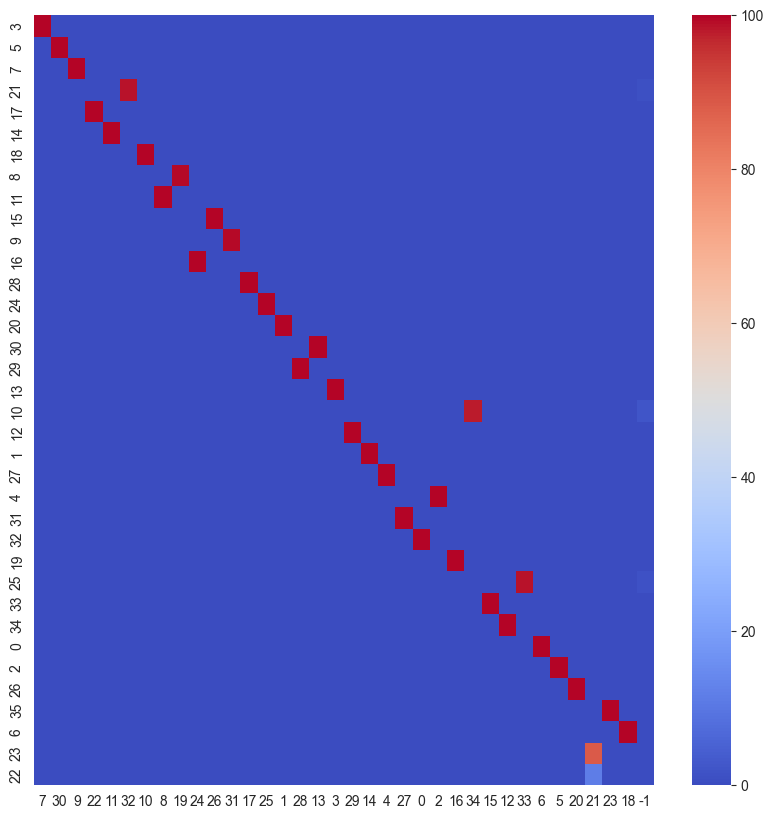

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

I = {}
for x in dfAc['umap'].value_counts().index:
  I[x] = {}
  for y in dfBc['umap'].value_counts().index:
    sA = set(dfAc[dfAc['umap'] == x]['FOLLOW'])
    sB = set(dfBc[dfBc['umap'] == y]['nodeId'])
    I[x][y] = 100 * len(sA & sB) / len(sA | sB)

fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(pd.DataFrame(I), cmap='coolwarm', annot=True, fmt=".0f")
sns.heatmap(pd.DataFrame(I), cmap='coolwarm')

## Close

In [27]:
#gds.graph.drop(G)
#gds.close()
#n4j.close()
#driver.close()